# Retrieve Processed Data From GitHub


*   Data Processing



In [1]:
import requests
import io
import csv
import torch


def get_sentences():
    urls = []
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/trainEncoded')
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/validEncoded')
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/testEncoded')
    raws = [requests.get(u).text for u in urls]
    separated = [csv.reader(io.StringIO(r)) for r in raws]
    processed = [[], [], []]
    for i in range(len(separated)):
        for row in separated[i]:
            idxs = row[2][1:-1].split(', ')
            if idxs[0] == '': continue
            idxs = list(map(int, idxs))
            idxs = torch.tensor([i % 10000 for i in idxs])
            label = torch.tensor(int(row[1] == '[76645]')).long()
            processed[i].append((idxs, label))

    return processed[0], processed[1], processed[2] # Train, valid, test as [(tensor([idx]), tensor(label))]

In [2]:
import requests
import io
import csv
import torch


def get_sentences_2(glove):
    url = 'https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/sms%2Bspam%2Bcollection/SMSSpamCollection'
    separated = csv.reader(io.StringIO(requests.get(url).text), delimiter='\t')
    spam, ham = [], []
    for row in separated:
        sentence = row[1].replace('.', ' . ') \
            .replace(',', ' , ') \
            .replace(';', ' ; ') \
            .replace('?', ' ? ')
        sentence = sentence.lower().split()
        idxs = [glove.stoi[w] for w in sentence if w in glove.stoi]
        if not idxs: continue
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(row[0] == 'spam')).long()
        if label.item() == 1:
            spam.append((idxs, label))
        elif label.item() == 0:
            ham.append((idxs, label))

    train, valid, test = [], [], []
    for i, example in enumerate(spam):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    train = [example for example in train for _ in range(6)]
    for i, example in enumerate(ham):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    return train, valid, test

In [3]:
import requests
import io
import csv
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
import random


def get_sentences_3():
    url = 'https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/sms%2Bspam%2Bcollection/SMSSpamCollection'
    separated = csv.reader(io.StringIO(requests.get(url).text), delimiter='\t')
    spam, ham = [], []
    for row in separated:
        if row[1] == '': continue
        label = int(row[0] == 'spam')
        if label == 1:
            spam.append((label, row[1]))
        elif label == 0:
            ham.append((label, row[1]))

    train, valid, test = [], [], []
    for i, example in enumerate(spam):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    train = [example for example in train for _ in range(6)]
    for i, example in enumerate(ham):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    return train, valid, test


def yield_tokens(sentences):
    for _, sentence in sentences:
        yield tokenizer(sentence)


def get_vocab(sentences):
    vocab = build_vocab_from_iterator(yield_tokens(sentences),
                                      specials=['<UNK>', '<BOS>', '<EOS>', '<PAD>'],
                                      max_tokens=20000)
    vocab.set_default_index(vocab['<UNK>'])
    return vocab


def collate_batch(batch):
    label_list, sentence_list = [], []
    for (_label, _sentence) in batch:
          label_list.append(_label)
          sentence_list.append(torch.tensor(sentence_transform(_sentence)))
    return torch.tensor(label_list), torch.transpose(pad_sequence(sentence_list, padding_value=3.0), 0, 1)


class BatchSamplerSimilarLength(Sampler):
    def __init__(self, sentences, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(sentences)]
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()


    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        for i in range(0, len(self.indices), self.batch_size * 100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))

        self.pooled_indices = [x[0] for x in pooled_indices]
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]
        if self.shuffle:
            random.shuffle(batches)

        for batch in batches:
            yield batch


    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

In [4]:
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader


train, valid, test = get_sentences_3()

tokenizer = get_tokenizer(lambda x: list(x))

vocab = get_vocab(train)

sentence_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]

train_loader = DataLoader(train, batch_sampler=BatchSamplerSimilarLength(
    sentences=train,
    batch_size=8), collate_fn=collate_batch)

# Create GRU and LSTM Network Models

In [11]:
import torch.nn as nn


class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(GRUNet, self).__init__()
        self.name = 'GRU'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, hidden=None):
        x = self.emb(x)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out


class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(LSTMNet, self).__init__()
        self.name = 'LSTM'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, h0c0=None):
        x = self.emb(x)
        out, _ = self.rnn(x, h0c0)
        out = self.fc(out[:, -1, :])
        return out


class LSTMNet_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(LSTMNet_2, self).__init__()
        self.name = 'LSTM'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)


    def forward(self, x, h0c0=None):
        x = self.emb(x)
        out, _ = self.rnn(x, h0c0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

# Batch Data With Same Length Randomly

In [31]:
import random


class Batcher:
    def __init__(self, sentences, batch_size=32, drop_last=False):
        self.batch_size = batch_size
        self.sentences_by_length = {}
        for sentence, label in sentences:
            len = sentence.size(0)
            if len not in self.sentences_by_length:
                self.sentences_by_length[len] = []

            self.sentences_by_length[len].append((sentence, label))

        self.loaders = {len: torch.utils.data.DataLoader(
                sentences,
                batch_size=batch_size,
                shuffle=True,
                drop_last=drop_last)
            for len, sentences in self.sentences_by_length.items()}


    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            it = random.choice(iters)
            try:
                yield next(it)

            except StopIteration:
                iters.remove(it)

# Evaluate Model Accuracy on Selected Data

In [13]:
def get_accuracy(model, loader):
    correct, total = 0, 0
    for sentences, labels in loader:
        if torch.cuda.is_available():
            sentences = sentences.cuda()
            labels = labels.cuda()

        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.size(0)

    return correct / total

# Generate File Path to Save Network Model

In [14]:
def get_file_path(name, glove, hidden_size, num_layers, batch_size, learning_rate):
    path = '{0}_{1}_hs{2}_nl{3}_bs{4}_lr{5}_'.format(name,
                                                     glove,
                                                     hidden_size,
                                                     num_layers,
                                                     batch_size,
                                                     learning_rate)
    return '/content/drive/MyDrive/Colab/' + path

# Train Network Model


*   https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize



In [29]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


def train_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    for epoch in range(num_epochs):
        for sentences, labels in train:
            if torch.cuda.is_available():
                sentences = sentences.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            pred = model(sentences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print('Epoch %d; Loss %f; Train Acc %f; Valid Acc %f' % (
            epoch, loss, train_acc[-1], valid_acc[-1]))
        path = get_file_path(model.name,
                             '6B50',
                             model.hidden_size,
                             model.num_layers,
                             train.batch_size,
                             learning_rate)
        torch.save(model.state_dict(), path + str(epoch))

    np.savetxt('{}losses.csv'.format(path), losses)
    np.savetxt('{}train.csv'.format(path), train_acc)
    np.savetxt('{}valid.csv'.format(path), valid_acc)

    plt.title('Loss Curve')
    plt.plot(losses, label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.title('Accuracy Curve')
    plt.plot(train_acc, label='Training')
    plt.plot(valid_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

# Evaluate Network Model

In [16]:
def get_scores(model, loader):
    tp, tn, fp, fn = 0, 0, 0, 0
    for sentences, labels in loader:
        if torch.cuda.is_available():
            sentences = sentences.cuda()
            labels = labels.cuda()

        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        results = pred * 2 + labels.view_as(pred)
        tp += results.eq(3).sum().item()
        tn += results.eq(0).sum().item()
        fp += results.eq(2).sum().item()
        fn += results.eq(1).sum().item()

    print('TP', tp, 'TN', tn, 'FP', fp, 'FN', fn)
    print('False Positive Rate', fp / (fp + tn))
    print('False Negative Rate', fn / (fn + tp))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    print('Recall', recall)
    print('Precision', precision)
    print('F1 Score', 2 * recall * precision / (recall + precision))

# Create Objects and Run Functions

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mon Apr  1 16:11:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              36W /  70W |    333MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

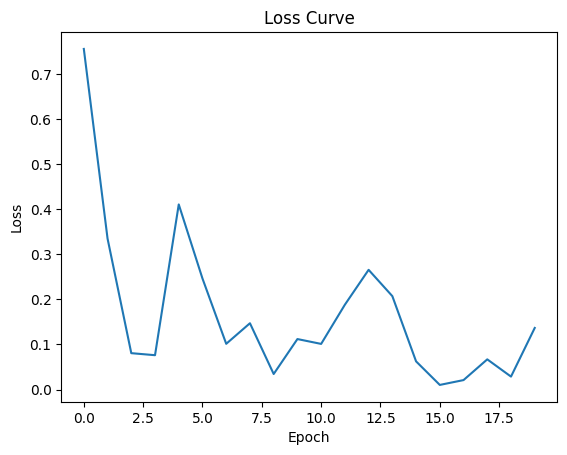

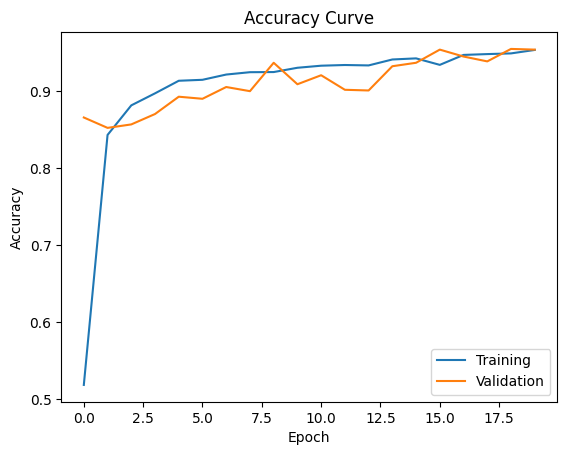

TP 139 TN 921 FP 41 FN 10
False Positive Rate 0.04261954261954262
False Negative Rate 0.06711409395973154
Recall 0.9328859060402684
Precision 0.7722222222222223
F1 Score 0.8449848024316109
Total Number of Parameters 581802


In [32]:
import torchtext


!nvidia-smi

random.seed(69)
torch.manual_seed(420)

glove = torchtext.vocab.GloVe(name='6B', dim=50, max_vectors=10000)

model = LSTMNet_2(50, 50, 2, glove, num_layers=4)
if torch.cuda.is_available():
    model.cuda()
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

train, valid, test = get_sentences_2(glove)

train_loader = Batcher(train, batch_size=32, drop_last=False)
valid_loader = Batcher(valid, batch_size=64, drop_last=False)
test_loader = Batcher(test, batch_size=64, drop_last=False)

train_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)

get_scores(model, valid_loader)

size = 0
for param in model.parameters():
    size += torch.numel(param)
print('Total Number of Parameters', size)

# Plot Training Curves of Selected Network Model

In [21]:
def plot_training_curves(path):
    losses = np.loadtxt('{}losses.csv'.format(path))
    train_acc = np.loadtxt('{}train.csv'.format(path))
    valid_acc = np.loadtxt('{}valid.csv'.format(path))

    plt.title('Loss Curve')
    plt.plot(losses, label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.title('Accuracy Curve')
    plt.plot(train_acc, label='Training')
    plt.plot(valid_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

# Detect Spam on Sample SMS Message

In [22]:
import torch.nn.functional as F


def evaluate_sample(sample, model, glove):
    sentence = sample.replace('.', ' . ') \
        .replace(',', ' , ') \
        .replace(';', ' ; ') \
        .replace('?', ' ? ')
    sentence = sentence.lower().split()
    idxs = torch.tensor([glove.stoi[w] for w in sentence if w in glove.stoi])
    if torch.cuda.is_available(): idxs = idxs.cuda()
    pred = model(idxs.unsqueeze(0))
    pred = F.softmax(pred, dim=1)[0, 1].item()
    print(sample)
    print('Probability of Spam', pred)

# Create More Objects and Run More Functions

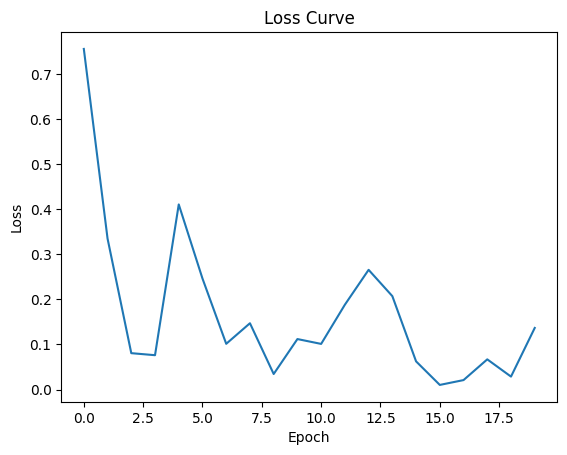

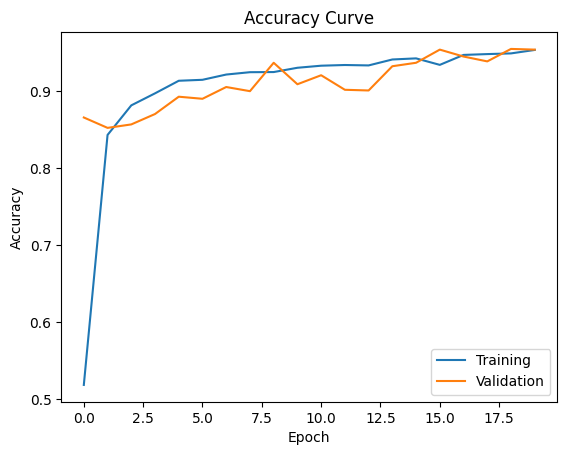

But let's just say it involves whipped cream and whipped cream
Probability of Spam 0.0019836691208183765
Congratulations! You’ve won a $500 Amazon gift card. Claim it here: tinyurl.com/sfcu6xxr
Probability of Spam 0.9935537576675415


In [33]:
tuned_model = LSTMNet_2(50, 50, 2, glove, num_layers=4)
if torch.cuda.is_available(): tuned_model.cuda()
path = get_file_path('LSTM',
                     '6B50',
                     50,
                     4,
                     32,
                     1e-4)
tuned_model.load_state_dict(torch.load(path + '19'))

plot_training_curves(path)

evaluate_sample('But let\'s just say it involves whipped cream and whipped cream', tuned_model, glove)
evaluate_sample('Congratulations! You’ve won a $500 Amazon gift card. Claim it here: tinyurl.com/sfcu6xxr', tuned_model, glove)